In [1]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import numpy as np
import os

In [2]:
train_data_dir = 'chest_xray/train'
test_data_dir = 'chest_xray/test'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=627)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=99390)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 9386 images belonging to 3 classes.


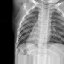

In [3]:
array_to_img(train_images[0])

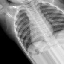

In [4]:
array_to_img(train_images[90])

In [5]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(9386, 64, 64, 3)
(9386, 3)
(624, 64, 64, 3)
(624, 2)


In [6]:
# Reshape the train images 
train_img_unrow = train_images.reshape(9386, -1).T

In [7]:
np.shape(train_img_unrow)

(12288, 9386)

In [8]:
test_img_unrow = test_images.reshape(624, -1).T

In [9]:
np.shape(test_img_unrow)

(12288, 624)

In [10]:
np.shape(train_labels)

(9386, 3)

In [11]:
train_generator.class_indices 

{'AUGMENTED_NORMAL': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [12]:
train_labels_final = train_labels.T[[1]]

In [13]:
np.shape(train_labels_final) 

(1, 9386)

In [14]:
test_labels_final = test_labels.T[[1]]

In [15]:
np.shape(test_labels_final) 

(1, 624)

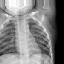

In [16]:
array_to_img(train_images[246])

In [28]:
train_labels_final[:,9000]

array([0.], dtype=float32)

In [29]:
train_img_final = train_img_unrow/225
test_img_final = test_img_unrow/225

type(test_img_unrow)

numpy.ndarray